# Introduction
The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task.

* **Supervised**: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* **Classification**: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

# Manual Setting

In [1]:
BaselineTraining = True
LogisticRegression = False
RandomForest = True

PolynomialFeaturesTesting = False
DomainFeaturesTesting = True

# Load In Data

## Training and Testing

In [3]:
import numpy as np
import pandas as pd
import gc

app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

print(f'Training Data Shape: {app_train.shape}')
print(f'Testing Data Shape: {app_test.shape}')

app_test.head()  


Training Data Shape: (307511, 122)
Testing Data Shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Reduce Memory Allotted Size

POS_CASH_balance, installments_payments, credit_card_balance

In [4]:
import numpy as np

def get_balance_data():
    pos_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int32, 'SK_DPD':np.int32,
        'SK_DPD_DEF':np.int32, 'CNT_INSTALMENT':np.float32,'CNT_INSTALMENT_FUTURE':np.float32
    }

    install_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'NUM_INSTALMENT_NUMBER':np.int32, 'NUM_INSTALMENT_VERSION':np.float32,
        'DAYS_INSTALMENT':np.float32, 'DAYS_ENTRY_PAYMENT':np.float32, 'AMT_INSTALMENT':np.float32, 'AMT_PAYMENT':np.float32
    }

    card_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int16,
        'AMT_CREDIT_LIMIT_ACTUAL':np.int32, 'CNT_DRAWINGS_CURRENT':np.int32, 'SK_DPD':np.int32,'SK_DPD_DEF':np.int32,
        'AMT_BALANCE':np.float32, 'AMT_DRAWINGS_ATM_CURRENT':np.float32, 'AMT_DRAWINGS_CURRENT':np.float32,
        'AMT_DRAWINGS_OTHER_CURRENT':np.float32, 'AMT_DRAWINGS_POS_CURRENT':np.float32, 'AMT_INST_MIN_REGULARITY':np.float32,
        'AMT_PAYMENT_CURRENT':np.float32, 'AMT_PAYMENT_TOTAL_CURRENT':np.float32, 'AMT_RECEIVABLE_PRINCIPAL':np.float32,
        'AMT_RECIVABLE':np.float32, 'AMT_TOTAL_RECEIVABLE':np.float32, 'CNT_DRAWINGS_ATM_CURRENT':np.float32,
        'CNT_DRAWINGS_OTHER_CURRENT':np.float32, 'CNT_DRAWINGS_POS_CURRENT':np.float32, 'CNT_INSTALMENT_MATURE_CUM':np.float32
    }

    pos_bal = pd.read_csv('POS_CASH_balance.csv', dtype=pos_dtype)
    install = pd.read_csv('installments_payments.csv', dtype=install_dtype)
    card_bal = pd.read_csv('credit_card_balance.csv', dtype=card_dtype)

    return pos_bal, install, card_bal

pos_bal, install, card_bal = get_balance_data()

# EDA

## Data Imbalanced

<AxesSubplot:ylabel='Frequency'>

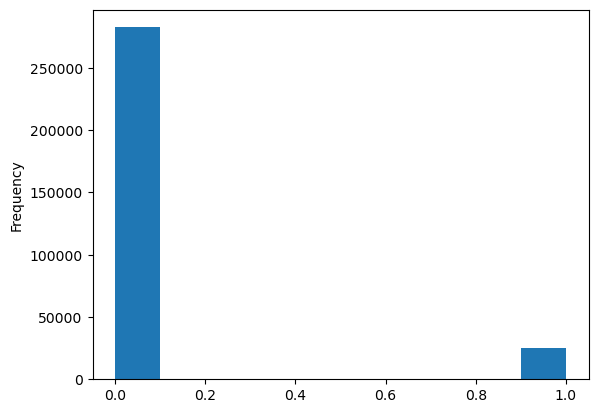

In [5]:
# app_train['TARGET'].value_counts()
app_train['TARGET'].astype(int).plot.hist()

## Missing Values

In [6]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can [handle missing values with no need for imputation.](https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase) Another option would be to drop columns with a high percentage of missing values.

## Column Types

In [8]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

## Unique Entries
of the `object`(categorical) columns.

In [9]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables!

### Encoding Categorical Variables

For categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories. 

Let's implement the policy described above: for any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

#### Label Encoding

In [10]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


#### One-Hot Encoding

In [11]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data.

* Only column labels that are present in both df1 and df2 are retained [(join='inner').](https://stackoverflow.com/questions/51645195/pandas-align-function-illustrative-example/51645550)

In [12]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


## Anomalies

Mis-typed numbers, errors in measuring equipment, or extreme measurements.

In [13]:
# (app_train['DAYS_BIRTH'] / -365).describe()
(app_train['DAYS_EMPLOYED'] / -365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

10       365243
17       365243
22       365243
26       365243
36       365243
          ...  
48717    365243
48728    365243
48731    365243
48735    365243
48736    365243
Name: DAYS_EMPLOYED, Length: 9274, dtype: int64

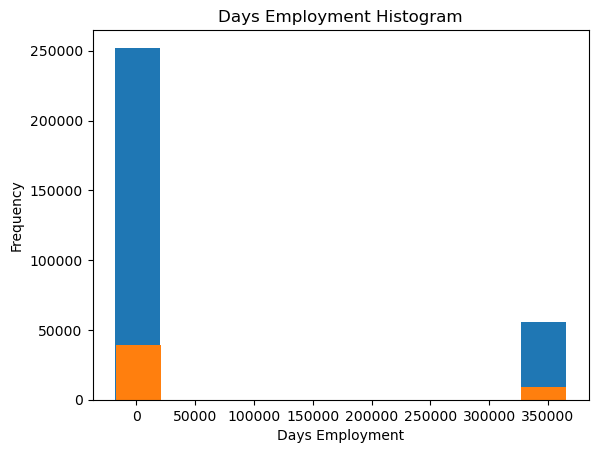

In [14]:
import matplotlib.pyplot as plt

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
app_test['DAYS_EMPLOYED'].plot.hist()
plt.xlabel('Days Employment')

app_test['DAYS_EMPLOYED'][app_test['DAYS_EMPLOYED'] > 200000]

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [15]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default. We will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

There are 9274 anomalies in the test data out of 48744 entries



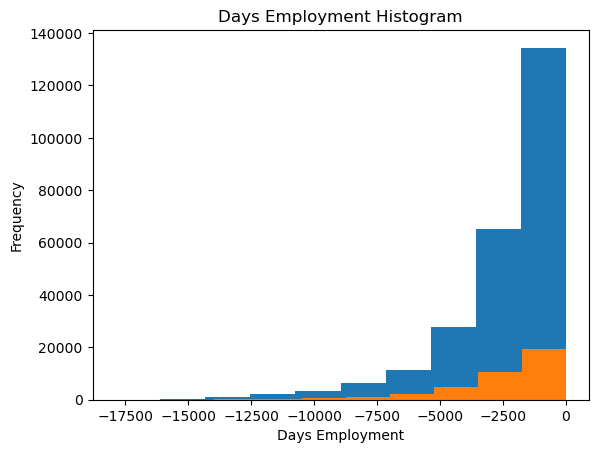

In [16]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
app_test['DAYS_EMPLOYED'].plot.hist()
plt.xlabel('Days Employment')

print('There are %d anomalies in the test data out of %d entries\n' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

## Correlations

In [17]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

### Effect of Age on Repayment

In [18]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

#### Distribution of Age

Text(0, 0.5, 'Count')

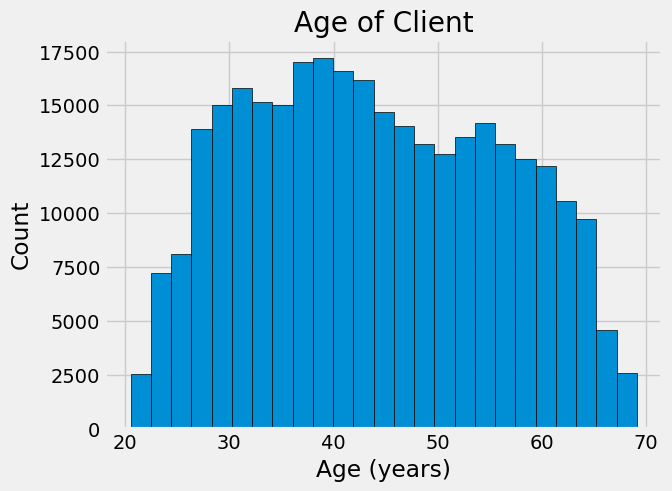

In [19]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

#### Visualize The Effect of The Age on The Target

Text(0.5, 1.0, 'Distribution of Ages')

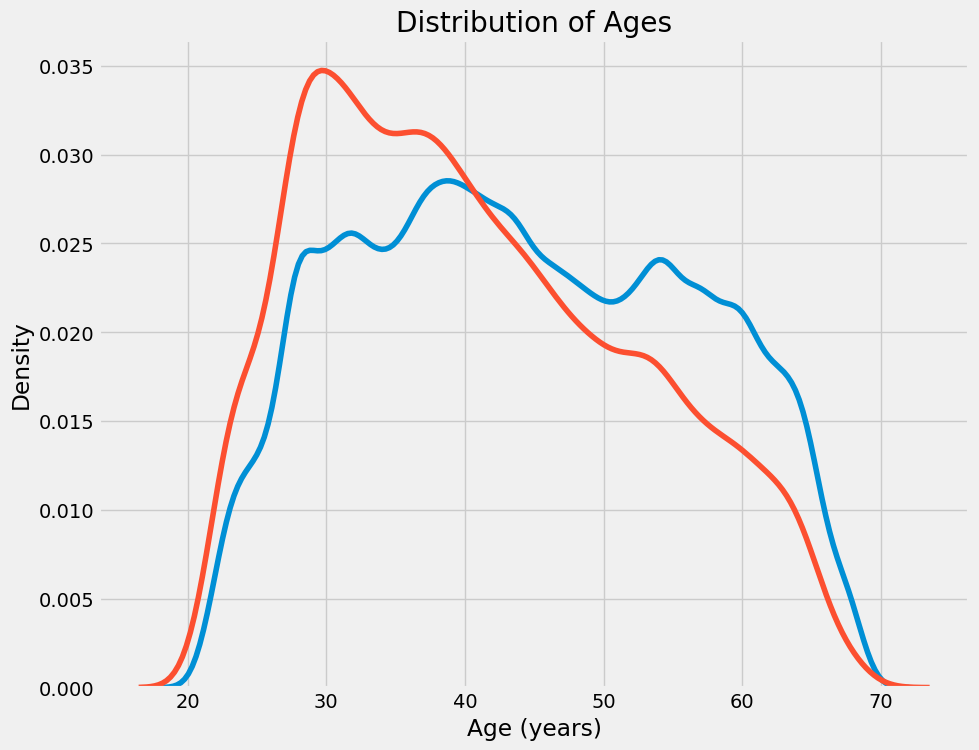

In [20]:
import seaborn as sns

plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [21]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

C:\Users\sxs3935\AppData\Local\Temp\ipykernel_9212\1136001900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
C:\Users\sxs3935\AppData\Local\Temp\ipykernel_9212\1136001900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [22]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Failure to Repay by Age Group')

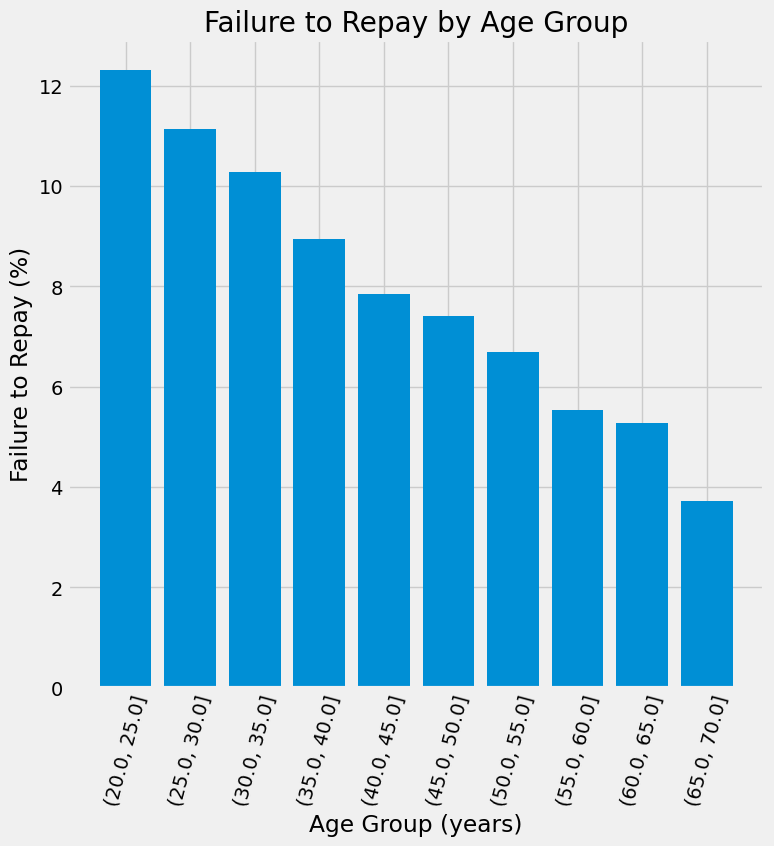

In [23]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.

In [24]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

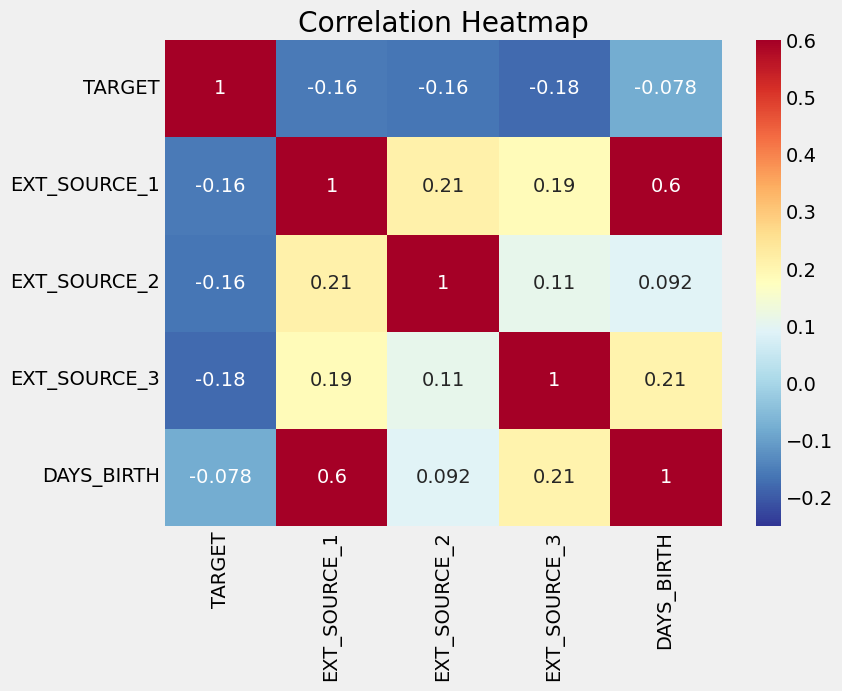

In [25]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

All three `EXT_SOURCE` featureshave negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan. We can also see that `DAYS_BIRTH` is positively correlated with `EXT_SOURCE_1` indicating that maybe one of the factors in this score is the client age.

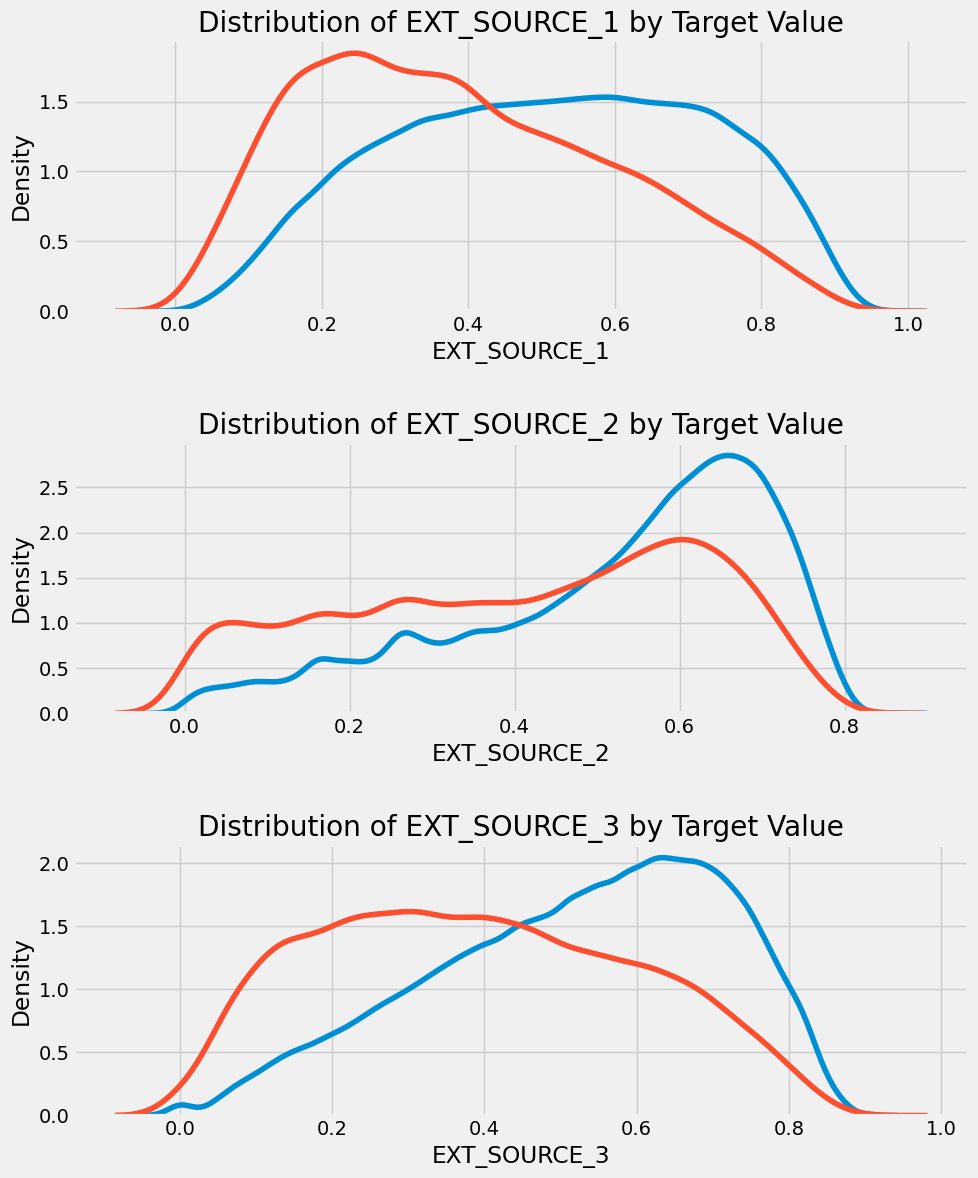

In [26]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# Feature Engineering (Example)

Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. This represents one of the patterns in machine learning: **Feature engineering has a greater return on investment than model building and hyperparameter tuning.** As Andrew Ng is fond of saying: **Applied machine learning is basically feature engineering.**

## Polynomial Features

Dealing with [ImportError](https://stackoverflow.com/questions/59439096/importerror-cannnot-import-name-imputer-from-sklearn-preprocessing): `cannot import name 'Imputer' from 'sklearn.preprocessing'`: <br>
It has been deprecated with **scikit-learn v0.20.4** and removed as of **v0.22.2**.

In [31]:
from sklearn.experimental import enable_iterative_imputer
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import random

In [41]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
# from sklearn.preprocessing import Imputer
# imputer = Imputer(strategy = 'median')
# cannot import name 'Imputer' from 'sklearn.preprocessing'

imputer = IterativeImputer(BayesianRidge())

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

In [135]:
poly_features.head()

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,TARGET,SK_ID_CURR
0,1.0,0.083037,0.262949,0.139376,9461.0,1,100002
1,1.0,0.311267,0.622246,0.512889,16765.0,0,100003
2,1.0,0.658075,0.555912,0.729567,19046.0,0,100004
3,1.0,0.656098,0.650442,0.546230,19005.0,0,100006
4,1.0,0.632616,0.322738,0.524245,19932.0,0,100007


In [42]:
from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 1)

In [43]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 5)


This creates a considerable number of new features. To get the names we have to use the polynomial features `get_feature_names` method.

In [44]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

C:\Users\sxs3935\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [45]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                         'EXT_SOURCE_3', 'DAYS_BIRTH']))
# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_3   -0.164677
EXT_SOURCE_2   -0.160341
EXT_SOURCE_1   -0.140165
DAYS_BIRTH     -0.078239
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64
EXT_SOURCE_2   -0.160341
EXT_SOURCE_1   -0.140165
DAYS_BIRTH     -0.078239
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


We will add these features to a copy of the training and testing data and then evaluate models with and without the features. The only way to know if an approach will work is to try it out!

In [46]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

C:\Users\sxs3935\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Training data with polynomial features shape:  (307511, 245)
Testing data with polynomial features shape:   (48744, 245)


## Domain Knowledge Features

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`: the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

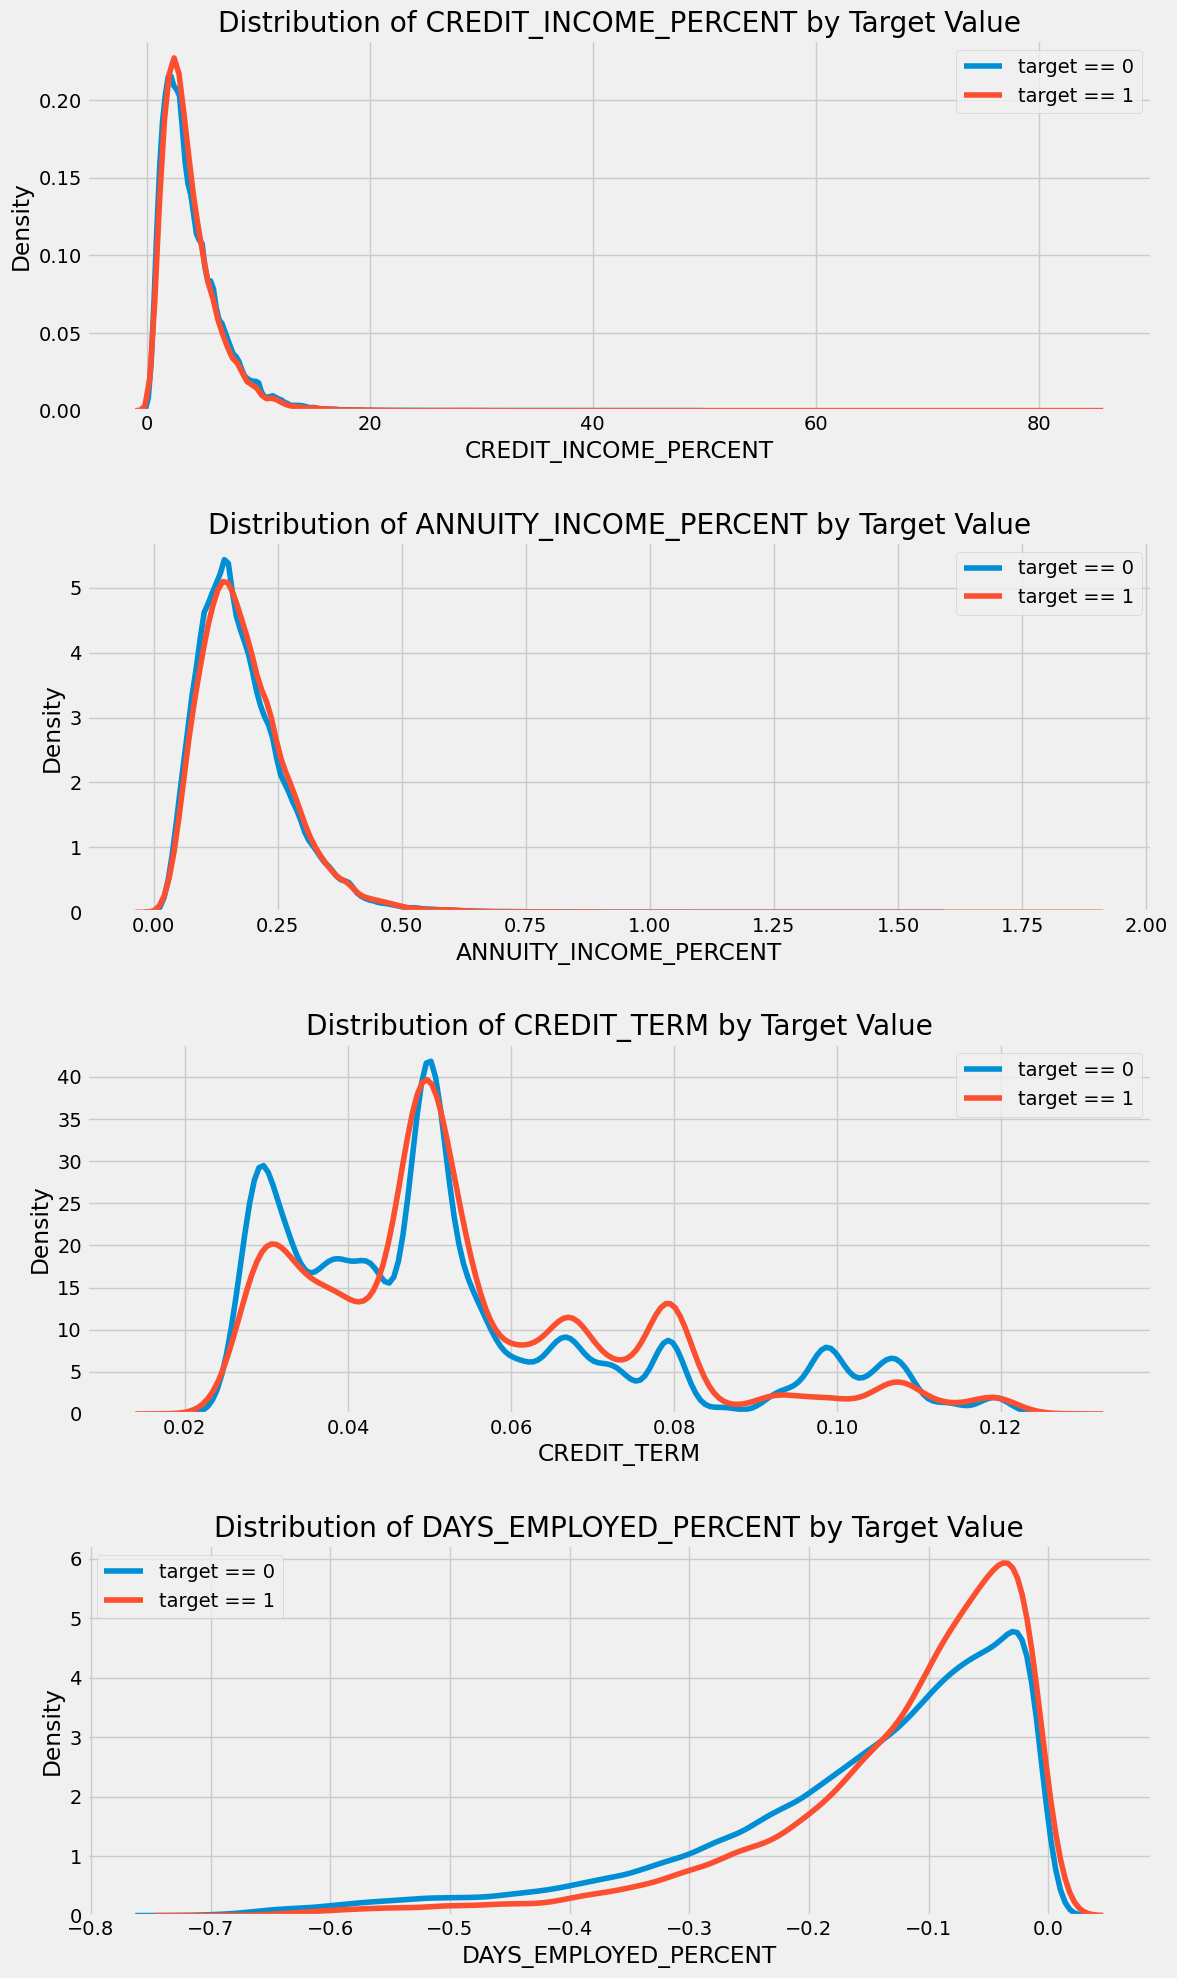

In [47]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # matplotlib.pyplot.legend
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    plt.legend()
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# Feature Engineering (Final)

In [48]:
def get_apps_processed(apps):
    """
    feature engineering for apps
    """

    # 1.EXT_SOURCE_X FEATURE 
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

In [49]:
def get_prev_processed(prev):
    """
    feature engineering 
    for previouse application credit history
    """
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']

    # Data Cleansing
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

    # substraction between DAYS_LAST_DUE_1ST_VERSION and DAYS_LAST_DUE
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

    # 1.Calculate the interest rate
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    return prev

def get_prev_amt_agg(prev):
    """
    feature engineering for the previous credit appliction
    """

    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
        
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]

    return prev_amt_agg

def get_prev_refused_appr_agg(prev):
    """
    PREV_APPROVED_COUNT : Credit application approved count
    PREV_REFUSED_COUNT :  Credit application refused count
    """
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    # unstack() 
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()

    # rename column 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]

    # NaN
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)

    return prev_refused_appr_agg

# DAYS_DECISION
def get_prev_days365_agg(prev):
    """
    DAYS_DESCISION means How many days have been take since the previous credit application made.
    Somehow this feature is important.
    """
    cond_days365 = prev['DAYS_DECISION'] > -365
    prev_days365_group = prev[cond_days365].groupby('SK_ID_CURR')
    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_days365_agg = prev_days365_group.agg(agg_dict)

    # multi index 
    prev_days365_agg.columns = ["PREV_D365_"+ "_".join(x).upper() for x in prev_days365_agg.columns.ravel()]

    return prev_days365_agg

def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    prev_days365_agg = get_prev_days365_agg(prev)
    
    # prev_amt_agg
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    prev_agg = prev_agg.merge(prev_days365_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR APPROVED_COUNT REFUSED_COUNT
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

In [50]:
def get_bureau_processed(bureau):
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
  
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']
    
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau

def get_bureau_day_amt_agg(bureau):
    bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],

    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    # SK_ID_CURR reset_index()
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    #print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
    return bureau_day_amt_agg

def get_bureau_active_agg(bureau):
    '''
    Bureau CREDIT_ACTIVE='Active' filtering
    SK_ID_CURR aggregation
    '''
    # CREDIT_ACTIVE='Active' filtering
    cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
    bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
    bureau_agg_dict = {
      'SK_ID_BUREAU':['count'],
      'DAYS_CREDIT':['min', 'max', 'mean'],
      'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
      'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
      'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
      'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
      'AMT_ANNUITY': ['max', 'mean', 'sum'],

      'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
      'BUREAU_IS_DPD':['mean', 'sum'],
      'BUREAU_IS_DPD_OVER120':['mean', 'sum']
      }

    bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
    bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
    # SK_ID_CURR reset_index() 
    bureau_active_agg = bureau_active_agg.reset_index()
    #print('bureau_active_agg shape:', bureau_active_agg.shape)
    return bureau_active_agg

# BUREAU DAYS_CREDIT -750
def get_bureau_days750_agg(bureau):
    cond_days750 = bureau['DAYS_CREDIT'] > -750
    bureau_days750_group = bureau[cond_days750].groupby('SK_ID_CURR')
    bureau_agg_dict = {
        'SK_ID_BUREAU':['count'],
        'DAYS_CREDIT':['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        
        'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
        'BUREAU_IS_DPD':['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120':['mean', 'sum']
        }

    bureau_days750_agg = bureau_days750_group.agg(bureau_agg_dict)
    bureau_days750_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_days750_agg.columns.ravel()]
    bureau_days750_agg = bureau_days750_agg.reset_index()
    
    return bureau_days750_agg

# bureau_bal SK_ID_CURR MONTHS_BALANCE aggregation
def get_bureau_bal_agg(bureau, bureau_bal):
    # SK_ID_CURR Group by bureau SK_ID_CURR 
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
    
    # STATUS 120
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    # SK_ID_CURR MONTHS_BALANCE aggregation
    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'max', 'mean'],
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]
    # SK_ID_CURR reset_index()
    bureau_bal_agg = bureau_bal_agg.reset_index()
    #print('bureau_bal_agg shape:', bureau_bal_agg.shape)
    return bureau_bal_agg

# bureau aggregation
def get_bureau_agg(bureau, bureau_bal):
    
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_days750_agg = get_bureau_days750_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    
    # bureau_day_amt_agg bureau_active_agg
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    # STATUS ACTIVE IS_DPD RATIO
    #bureau_agg['BUREAU_IS_DPD_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    #bureau_agg['BUREAU_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    
    # bureau_agg bureau_bal_agg
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    bureau_agg = bureau_agg.merge(bureau_days750_agg, on='SK_ID_CURR', how='left') 
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_OVER120_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']

    #print('bureau_agg shape:', bureau_agg.shape)
    
    return bureau_agg

In [51]:
def get_pos_bal_agg(pos_bal):
    # (SK_DPD) 0 , 0~ 100 , 100
    cond_over_0 = pos_bal['SK_DPD'] > 0
    cond_100 = (pos_bal['SK_DPD'] < 100) & (pos_bal['SK_DPD'] > 0)
    cond_over_100 = (pos_bal['SK_DPD'] >= 100)

    # 0~ 120 120
    pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # SK_ID_CURR aggregation
    pos_bal_grp = pos_bal.groupby('SK_ID_CURR')
    pos_bal_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)

    pos_bal_agg.columns = [('POS_')+('_').join(column).upper() for column in pos_bal_agg.columns.ravel()]
    
    # MONTHS_BALANCE (20)
    cond_months = pos_bal['MONTHS_BALANCE'] > -20
    pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
    pos_bal_m20_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
 
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_m20_agg_dict)

    pos_bal_m20_agg.columns = [('POS_M20')+('_').join(column).upper() for column in pos_bal_m20_agg.columns.ravel()]
    pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, on='SK_ID_CURR', how='left')
    
    # SK_ID_CURR reset_index()
    pos_bal_agg = pos_bal_agg.reset_index()
    
    
    return pos_bal_agg

In [52]:
def get_install_agg(install):
    # DPD  
    install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
    install['AMT_RATIO'] =  (install['AMT_PAYMENT'] +1)/ (install['AMT_INSTALMENT'] + 1)
    install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']

    # 30~ 120 100
    install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # SK_ID_CURR aggregation
    install_grp = install.groupby('SK_ID_CURR')

    install_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],

        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }

    install_agg = install_grp.agg(install_agg_dict)
    install_agg.columns = ['INS_'+('_').join(column).upper() for column in install_agg.columns.ravel()]

    
    # (DAYS_ENTRY_PAYMENT) (1)
    cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365
    install_d365_grp = install[cond_day].groupby('SK_ID_CURR')
    install_d365_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],

        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }
    
    install_d365_agg = install_d365_grp.agg(install_d365_agg_dict)
    install_d365_agg.columns = ['INS_D365'+('_').join(column).upper() for column in install_d365_agg.columns.ravel()]
    
    install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')
    install_agg = install_agg.reset_index()
    
    return install_agg

In [53]:
def get_card_bal_agg(card_bal):
    card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE']/card_bal['AMT_CREDIT_LIMIT_ACTUAL']
    card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

    # DPD
    card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # SK_ID_CURR aggregation
    card_bal_grp = card_bal.groupby('SK_ID_CURR')
    card_bal_agg_dict = {
        'SK_ID_CURR':['count'],
         #'MONTHS_BALANCE':['min', 'max', 'mean'],
        'AMT_BALANCE':['max'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],

        'BALANCE_LIMIT_RATIO':['min','max'],
        'DRAWING_LIMIT_RATIO':['min', 'max'],
        'CARD_IS_DPD':['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
        'CARD_IS_DPD_OVER_120':['mean', 'sum']    
    }
    card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
    card_bal_agg.columns = ['CARD_'+('_').join(column).upper() for column in card_bal_agg.columns.ravel()]

    card_bal_agg = card_bal_agg.reset_index()
    
    # MONTHS_BALANCE (3)
    cond_month = card_bal.MONTHS_BALANCE >= -3
    card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')
    card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
    card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.columns.ravel()]
    
    card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
    card_bal_agg = card_bal_agg.reset_index()
    
    return card_bal_agg

# Training (Baseline)

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

if BaselineTraining:
    
    if 'TARGET' in app_train:
        train = app_train.drop(columns = ['TARGET'])
    else:
        train = app_train.copy()

    test = app_test.copy()
    features = list(train.columns)

    imputer.fit(train)
    # Median imputation of missing values
    train = imputer.transform(train)
    test = imputer.transform(app_test)

    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)

    print('Training data shape:', train.shape)
    print('Testing data shape:', test.shape)
    
    if LogisticRegression:

        # Make the model with the specified regularization parameter
        log_reg = LogisticRegression(C = 0.0001)

        # Train on the training data
        log_reg.fit(train, train_labels)

        # Make predictions
        # Make sure to select the second column only
        log_reg_pred = log_reg.predict_proba(test)[:, 1]

        # Submission dataframe
        submit = app_test[['SK_ID_CURR']].copy()
        submit.loc[:, 'TARGET'] = log_reg_pred

        # submit.head()

        # Save the submission to a csv file
        submit.to_csv('log_reg_baseline.csv', index = False)
    
    if RandomForest:

        # Make the random forest classifier
        random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

        # Train on the training data
        random_forest.fit(train, train_labels)

        # Extract feature importances
        feature_importance_values = random_forest.feature_importances_
        feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

        # Make predictions on the test data
        predictions = random_forest.predict_proba(test)[:, 1]

        # Make a submission dataframe
        submit = app_test[['SK_ID_CURR']].copy()
        submit.loc[:, 'TARGET'] = predictions

        # submit.head()

        # Save the submission dataframe
        submit.to_csv('random_forest_baseline.csv', index = False)

KeyboardInterrupt: 

# Training (Engineered Features Implemented)

In [ ]:
if PolynomialFeaturesTesting:
    poly_features_names = list(app_train_poly.columns)

    poly_features = imputer.fit_transform(app_train_poly)
    poly_features_test = imputer.transform(app_test_poly)

    poly_features = scaler.fit_transform(poly_features)
    poly_features_test = scaler.transform(poly_features_test)

    random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

    # Train on the training data
    random_forest_poly.fit(poly_features, train_labels)

    # Make predictions on the test data
    predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

    # Make a submission dataframe
    submit = app_test[['SK_ID_CURR']].copy()
    submit.loc[:, 'TARGET'] = predictions

    submit.head()

    # Save the submission dataframe
    submit.to_csv('random_forest_baseline_engineered.csv', index = False)

if DomainFeaturesTesting:
    app_train_domain = app_train_domain.drop(columns = 'TARGET')

    domain_features_names = list(app_train_domain.columns)

    domain_features = imputer.fit_transform(app_train_domain)
    domain_features_test = imputer.transform(app_test_domain)

    domain_features = scaler.fit_transform(domain_features)
    domain_features_test = scaler.transform(domain_features_test)

    random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

    # Train on the training data
    random_forest_domain.fit(domain_features, train_labels)

    # Extract feature importances
    feature_importance_values_domain = random_forest_domain.feature_importances_
    feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

    # Make predictions on the test data
    predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

    # Make a submission dataframe
    submit = app_test[['SK_ID_CURR']].copy()
    submit.loc[:, 'TARGET'] = predictions

    # Save the submission dataframe
    submit.to_csv('random_forest_baseline_domain.csv', index = False)

# Feature Importances (Example)

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
feature_importances_sorted = plot_feature_importances(feature_importances)

In [ ]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

# Reload The Original Datasets For Final Training

In [55]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [62]:
def get_dataset():
    """
    load datasets
    1.app_train - train dataset 
    2.app_test - test datasets
    3.apps - concatenated app_train, app_test
    4.pos_bal - POS_CACHE
    5.install - installments_payments
    6.card_bal - Credit Card
    """
    app_train = pd.read_csv('application_train.csv')
    app_test = pd.read_csv('application_test.csv')
    apps = pd.concat([app_train, app_test])

    prev = pd.read_csv('previous_application.csv')
    bureau = pd.read_csv('bureau.csv')
    bureau_bal = pd.read_csv('bureau_balance.csv')

    pos_bal, install, card_bal = get_balance_data()

    return apps, prev, bureau, bureau_bal, pos_bal, install, card_bal

apps, prev, bureau, bureau_bal, pos_bal, install, card_bal = get_dataset()

## Datasets Concatenation and Join

In [57]:
# apps prev_agg, bureau_agg, pos_bal_agg, install_agg, card_bal_agg
def get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal):
    """
    Description :
    1.Data preparation , aggregation 
    2.produce the finalized result
    """
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    bureau_agg = get_bureau_agg(bureau, bureau_bal)
    pos_bal_agg = get_pos_bal_agg(pos_bal)
    install_agg = get_install_agg(install)
    card_bal_agg = get_card_bal_agg(card_bal)
    print('prev_agg shape:', prev_agg.shape, 'bureau_agg shape:', bureau_agg.shape )
    print('pos_bal_agg shape:', pos_bal_agg.shape, 'install_agg shape:', install_agg.shape, 'card_bal_agg shape:', card_bal_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)

    # Join with apps_all
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(bureau_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(pos_bal_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(install_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(card_bal_agg, on='SK_ID_CURR', how='left')

    print('apps_all after merge with all shape:', apps_all.shape)

    return apps_all

In [58]:
def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

# Final Training (LGBM)

In [97]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test

def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.2, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
                nthread=4,
                n_estimators=2000,
                learning_rate=0.05,
                max_depth = 11,
                num_leaves=58,
                colsample_bytree=0.613,
                subsample=0.708,
                max_bin=407,
                reg_alpha=3.564,
                reg_lambda=4.930,
                min_child_weight= 6,
                min_child_samples=165,
                silent=-1,
                verbose=-1,
                )
   
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 200)
    
    return clf

In [63]:
# application, previous, bureau, bureau_bal
apps_all = get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal)


# Category Label
apps_all = get_apps_all_encoded(apps_all)

apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)

C:\Users\sxs3935\AppData\Local\Temp\ipykernel_9212\2157000831.py:56: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
C:\Users\sxs3935\AppData\Local\Temp\ipykernel_9212\2157000831.py:107: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  prev_days365_agg.columns = ["PREV_D365_"+ "_".join(x).upper() for x in prev_days365_agg.columns.ravel()]
C:\Users\sxs3935\AppData\Local\Temp\ipykernel_9212\132016959.py:39: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
C:\Users\sxs3935\AppData\Local\Temp\ipykernel_9212\132016959.py:75: FutureWarning: Index.ravel returning ndarray is deprecated; in a f

prev_agg shape: (338857, 80) bureau_agg shape: (305811, 149)
pos_bal_agg shape: (337252, 45) install_agg shape: (339587, 59) card_bal_agg shape: (103558, 70)
apps_all before merge shape: (356255, 135)
apps_all after merge with all shape: (356255, 534)


In [ ]:
del apps,prev,bureau,bureau_bal,pos_bal,install,card_bal
gc.collect()

In [77]:
print(apps_all_train.shape, apps_all_test.shape)

(307511, 534) (48744, 533)


Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'CARD_M3BALANCE_LIMIT_RATIO_MIN', 'CARD_M3BALANCE_LIMIT_RATIO_MAX',
       'CARD_M3DRAWING_LIMIT_RATIO_MIN', 'CARD_M3DRAWING_LIMIT_RATIO_MAX',
       'CARD_M3CARD_IS_DPD_MEAN', 'CARD_M3CARD_IS_DPD_SUM',
       'CARD_M3CARD_IS_DPD_UNDER_120_MEAN', 'CARD_M3CARD_IS_DPD_UNDER_120_SUM',
       'CARD_M3CARD_IS_DPD_OVER_120_MEAN', 'CARD_M3CARD_IS_DPD_OVER_120_SUM'],
      dtype='object', length=534)

In [98]:
clf = train_apps_all(apps_all_train)

train shape: (246008, 532) valid shape: (61503, 532)


C:\Users\sxs3935\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sxs3935\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sxs3935\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed 

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[100]	training's auc: 0.795147	training's binary_logloss: 0.239626	valid_1's auc: 0.771834	valid_1's binary_logloss: 0.242461
[200]	training's auc: 0.817614	training's binary_logloss: 0.228455	valid_1's auc: 0.783191	valid_1's binary_logloss: 0.23652
[300]	training's auc: 0.833585	training's binary_logloss: 0.221249	valid_1's auc: 0.788433	valid_1's binary_logloss: 0.234252
[400]	training's auc: 0.846876	training's binary_logloss: 0.215477	valid_1's auc: 0.790884	valid_1's binary_logloss: 0.233177
[500]	training's auc: 0.858556	training's binary_logloss: 0.210423	valid_1's auc: 0.792658	valid_1's binary_logloss: 0.232441
[600]	training's auc: 0.868857	training's binary_logloss: 0.20588	valid_1's auc: 0.793412	valid_1's binary_logloss: 0.232075
[700]	training's auc: 0.878252	training's binary_logloss: 0.20169	valid_1's auc: 0.793844	valid_1's binary_logloss: 0.231865
[800]	tr

# Prediction

In [73]:
apps_all_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CARD_M3BALANCE_LIMIT_RATIO_MAX,CARD_M3DRAWING_LIMIT_RATIO_MIN,CARD_M3DRAWING_LIMIT_RATIO_MAX,CARD_M3CARD_IS_DPD_MEAN,CARD_M3CARD_IS_DPD_SUM,CARD_M3CARD_IS_DPD_UNDER_120_MEAN,CARD_M3CARD_IS_DPD_UNDER_120_SUM,CARD_M3CARD_IS_DPD_OVER_120_MEAN,CARD_M3CARD_IS_DPD_OVER_120_SUM,TARGET
307511,100001,0,1,0,0,0,135000.0,568800.0,20560.5,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028826
307512,100005,0,0,0,0,0,99000.0,222768.0,17370.0,180000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.190967
307513,100013,0,0,1,0,0,202500.0,663264.0,69777.0,630000.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.053009
307514,100028,0,1,0,0,2,315000.0,1575000.0,49018.5,1575000.0,...,0.165937,0.066709,0.101438,0.0,0.0,0.0,0.0,0.0,0.0,0.039986
307515,100038,0,0,1,1,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.210296


In [99]:
preds = clf.predict_proba(apps_all_test.drop(['SK_ID_CURR'], axis=1))[:, 1]
#apps_all_test['TARGET'] = preds
#apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(output_dir,'pos_install_credit_02.csv'), index=False)
#apps_all_test[['SK_ID_CURR', 'TARGET']]

In [100]:
new_final_sub = pd.DataFrame({'SK_ID_CURR': apps_all_test['SK_ID_CURR'], 'TARGET': preds})
new_final_sub.to_csv('new_final_submission.csv', index=False)

In [ ]:
# best: around 0.794

### Weighted Average

In [110]:
r1 = pd.read_csv("r1.csv") # 5-fold with less features
r2 = pd.read_csv("r2.csv") # 5-fold current
r3 = pd.read_csv("best_mix_submission.csv") # 5-fold previous 

In [111]:
import functools as ft
dfs = [r1,r2,r3]
df_auc = ft.reduce(lambda left, right: pd.merge(left, right, on='SK_ID_CURR'), dfs)
df_auc.drop('SK_ID_CURR', axis=1, inplace=True)
df_auc.head(3)

,TARGET_x,TARGET_y,TARGET
0,0.029785,0.535257,0.036623
1,0.171369,0.880331,0.150372
2,0.056748,0.258531,0.034578


In [125]:
rmix = r1.copy(deep=True)
rmix['TARGET'] = 0.7*r1["TARGET"]+0.3*r2["TARGET"]
rmix.to_csv("best_submission.csv", index = False)

In [ ]:
# best: around 0.799

In [166]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 12
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:30]))), 
            df['importance_normalized'].head(30), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:30]))))
    ax.set_yticklabels(df['feature'].head(30))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

In [151]:
df_lgb = pd.DataFrame({'feature': apps_all_train.drop(columns=['TARGET','SK_ID_CURR']).columns.values, 
                                        'importance': clf.feature_importances_})
df_lgb.head()

,feature,importance
0,NAME_CONTRACT_TYPE,25
1,CODE_GENDER,247
2,FLAG_OWN_CAR,6
3,FLAG_OWN_REALTY,39
4,CNT_CHILDREN,41


In [160]:
df_lgb_sub = df_lgb.copy(deep=True)
df_lgb_sub = df_lgb_sub[~df_lgb_sub.feature.isin(['POS_M20CNT_INSTALMENT_FUTURE_MEAN','PREV_PREV_INTERESTS_RATE_MEAN',
                                       'PREV_PREV_CREDIT_APPL_RATIO_MEAN','BUREAU_BUREAU_CREDIT_DEBT_DIFF_MEAN',
                                       'BUREAU_ACT_DAYS_CREDIT_ENDDATE_MIN_x','BUREAU_BUREAU_CREDIT_FACT_DIFF_MEAN',
                                       'BUREAU_BUREAU_CREDIT_DEBT_DIFF_MIN','BUREAU_BUREAU_CREDIT_DEBT_DIFF_MIN',
                                       'INS_SK_DPD_MIN','BUREAU_BUREAU_ENDDATE_FACT_DIFF_MEAN','PREV_PREV_CREDIT_DIFF_MAX'])]

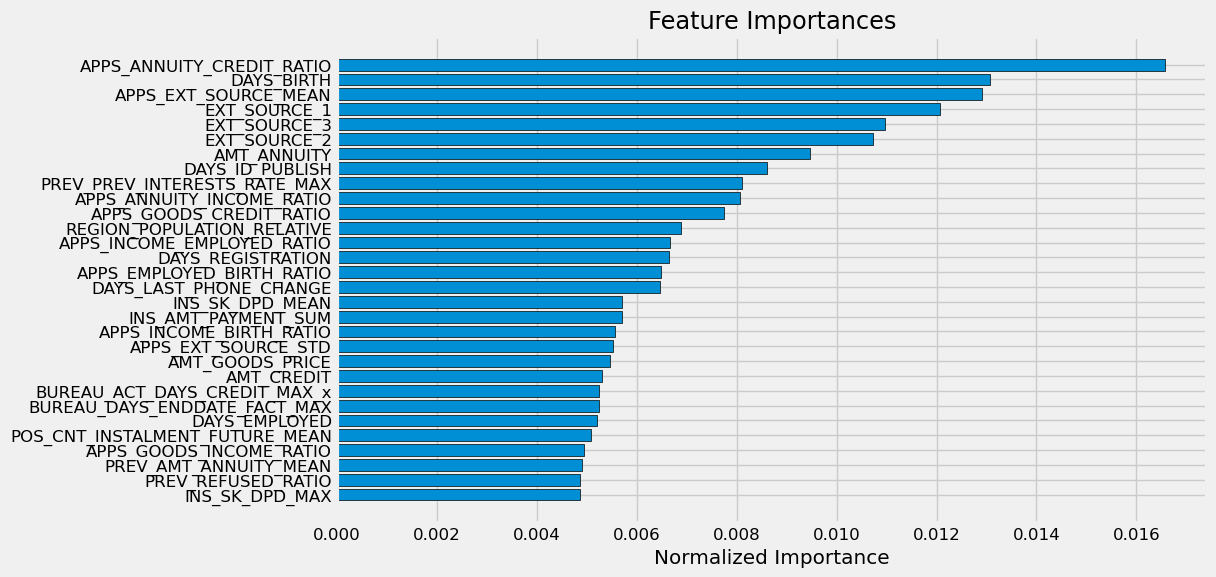

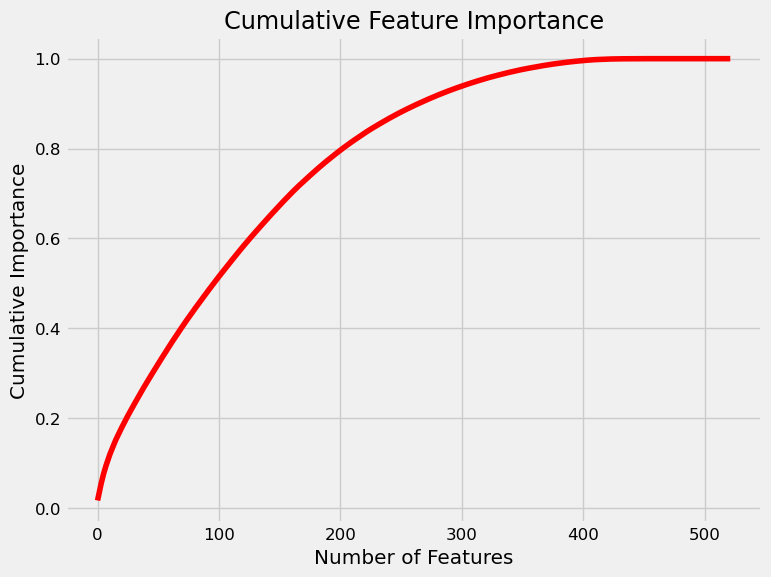

266 features required for 0.90 of cumulative importance


In [167]:
lgb_feature_importances = plot_feature_importances(df_lgb_sub, threshold = 0.9)

In [154]:
lgb_feature_importances.head(100)

,index,feature,importance,importance_normalized,cumulative_importance
0,122,APPS_ANNUITY_CREDIT_RATIO,1354,0.015629,0.015629
1,15,DAYS_BIRTH,1067,0.012316,0.027945
2,120,APPS_EXT_SOURCE_MEAN,1054,0.012166,0.040111
3,39,EXT_SOURCE_1,986,0.011381,0.051492
4,41,EXT_SOURCE_3,895,0.010331,0.061823
5,40,EXT_SOURCE_2,876,0.010111,0.071934
6,7,AMT_ANNUITY,773,0.008922,0.080856
7,18,DAYS_ID_PUBLISH,703,0.008115,0.088971
8,397,POS_M20CNT_INSTALMENT_FUTURE_MEAN,697,0.008045,0.097016
9,171,PREV_PREV_INTERESTS_RATE_MAX,662,0.007641,0.104657


In [138]:
clf.feature_importances_

532

### Fit logistic regression for best 30 variables

In [168]:
import statsmodels.api as sm

In [171]:
top30 = list(df_lgb_sub.sort_values("importance", ascending = False).head(30)['feature']
             

AttributeError: 'list' object has no attribute 'tail'

In [189]:
X30 = apps_all_train.copy(deep=True)
X30 = X30[top30]
X30['TARGET'] = train_labels
X30 = X30[~X30.isin([np.nan, np.inf, -np.inf]).any(1)]
y30 = X30['TARGET']
X30 = X30.drop(columns=['TARGET'])
X30.shape

(76730, 30)

In [190]:
model = sm.Logit(y30, X30).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.229983
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:                76730
Model:                          Logit   Df Residuals:                    76700
Method:                           MLE   Df Model:                           29
Date:                Fri, 28 Apr 2023   Pseudo R-squ.:                  0.1224
Time:                        22:49:17   Log-Likelihood:                -17647.
converged:                       True   LL-Null:                       -20107.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
APPS_ANNUITY_CREDIT_RATIO         -4.9982      1.253     -3.990     

In [192]:
params = model.params
conf = model.conf_int() # 95% Confidence interval
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = model.pvalues
odds['significant?'] = ['significant' if pval < 0.05 else 'not significant' for pval in model.pvalues]
odds['positive?'] = ['positive' if param_i >= 0 else 'negative' for param_i in model.params]
#odds = odds.drop(['REGION_POPULATION_RELATIVE', 'const', 'DEBT_CREDIT_RATIO', "INSTA_NUM_INSTALMENT_VERSION"])
odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?,positive?
APPS_ANNUITY_CREDIT_RATIO,0.000579,0.078648,0.006750,6.616692e-05,significant,negative
DAYS_BIRTH,0.999933,0.999955,0.999944,4.018585e-24,significant,negative
APPS_EXT_SOURCE_MEAN,NaN,NaN,0.168993,NaN,not significant,negative
EXT_SOURCE_1,NaN,NaN,0.126430,NaN,not significant,negative
EXT_SOURCE_3,NaN,NaN,0.131771,NaN,not significant,negative
EXT_SOURCE_2,NaN,NaN,0.289692,NaN,not significant,negative
AMT_ANNUITY,1.000008,1.000020,1.000014,2.067649e-05,significant,positive
DAYS_ID_PUBLISH,1.000020,1.000059,1.000039,9.119213e-05,significant,positive
PREV_PREV_INTERESTS_RATE_MAX,96.661755,31268.407612,1738.522122,4.180085e-07,significant,positive
APPS_ANNUITY_INCOME_RATIO,1.991520,15.359832,5.530770,1.031271e-03,significant,positive


In [205]:
odds.loc[['EXT_SOURCE_1']].iloc[0,[0,1]] = [0.120789,0.126430+(0.126430-0.120789)]
odds.loc[['EXT_SOURCE_2']].iloc[0,[0,1]] = [0.289692-0.008155,0.289692+0.008155]
odds.loc[['EXT_SOURCE_3']].iloc[0,[0,1]] = [0.131771-0.005601,0.131771+0.005601]
odds.loc[['APPS_EXT_SOURCE_MEAN']].iloc[0,[0,1]] = [0.168993-0.000345,0.168993+0.000345]
odds = odds.drop(['PREV_PREV_INTERESTS_RATE_MAX'])

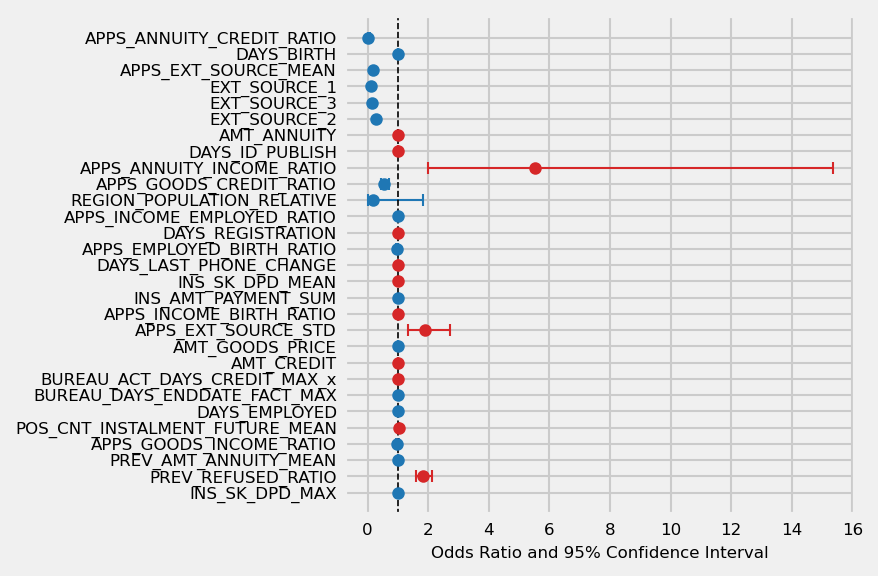

In [206]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
for idx, row in odds.iloc[::-1].iterrows():
    ci = [[row['Odds Ratio'] - row[::-1]['2.5%']], [row['97.5%'] - row['Odds Ratio']]]
    if row['positive?'] == 'positive':
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red", label=">=1")
    else:
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:blue', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:blue", mec="tab:blue", label="<1")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
plt.savefig('forest_plot.png')
plt.show()